In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.regression import *

### pycaret 설치 가이드 (Python 3.8 기준)

1. pip install pycaret==3.1.0

2. pip install joblib==1.4.2

In [49]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [50]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [51]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [52]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
HbA1c             0
Biological Sex    0
CVSD              0
WakeTime          0
label             0
Length: 78, dtype: int64

In [53]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [54]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [55]:
corrdf = df.drop(columns=['datetime']).corr()

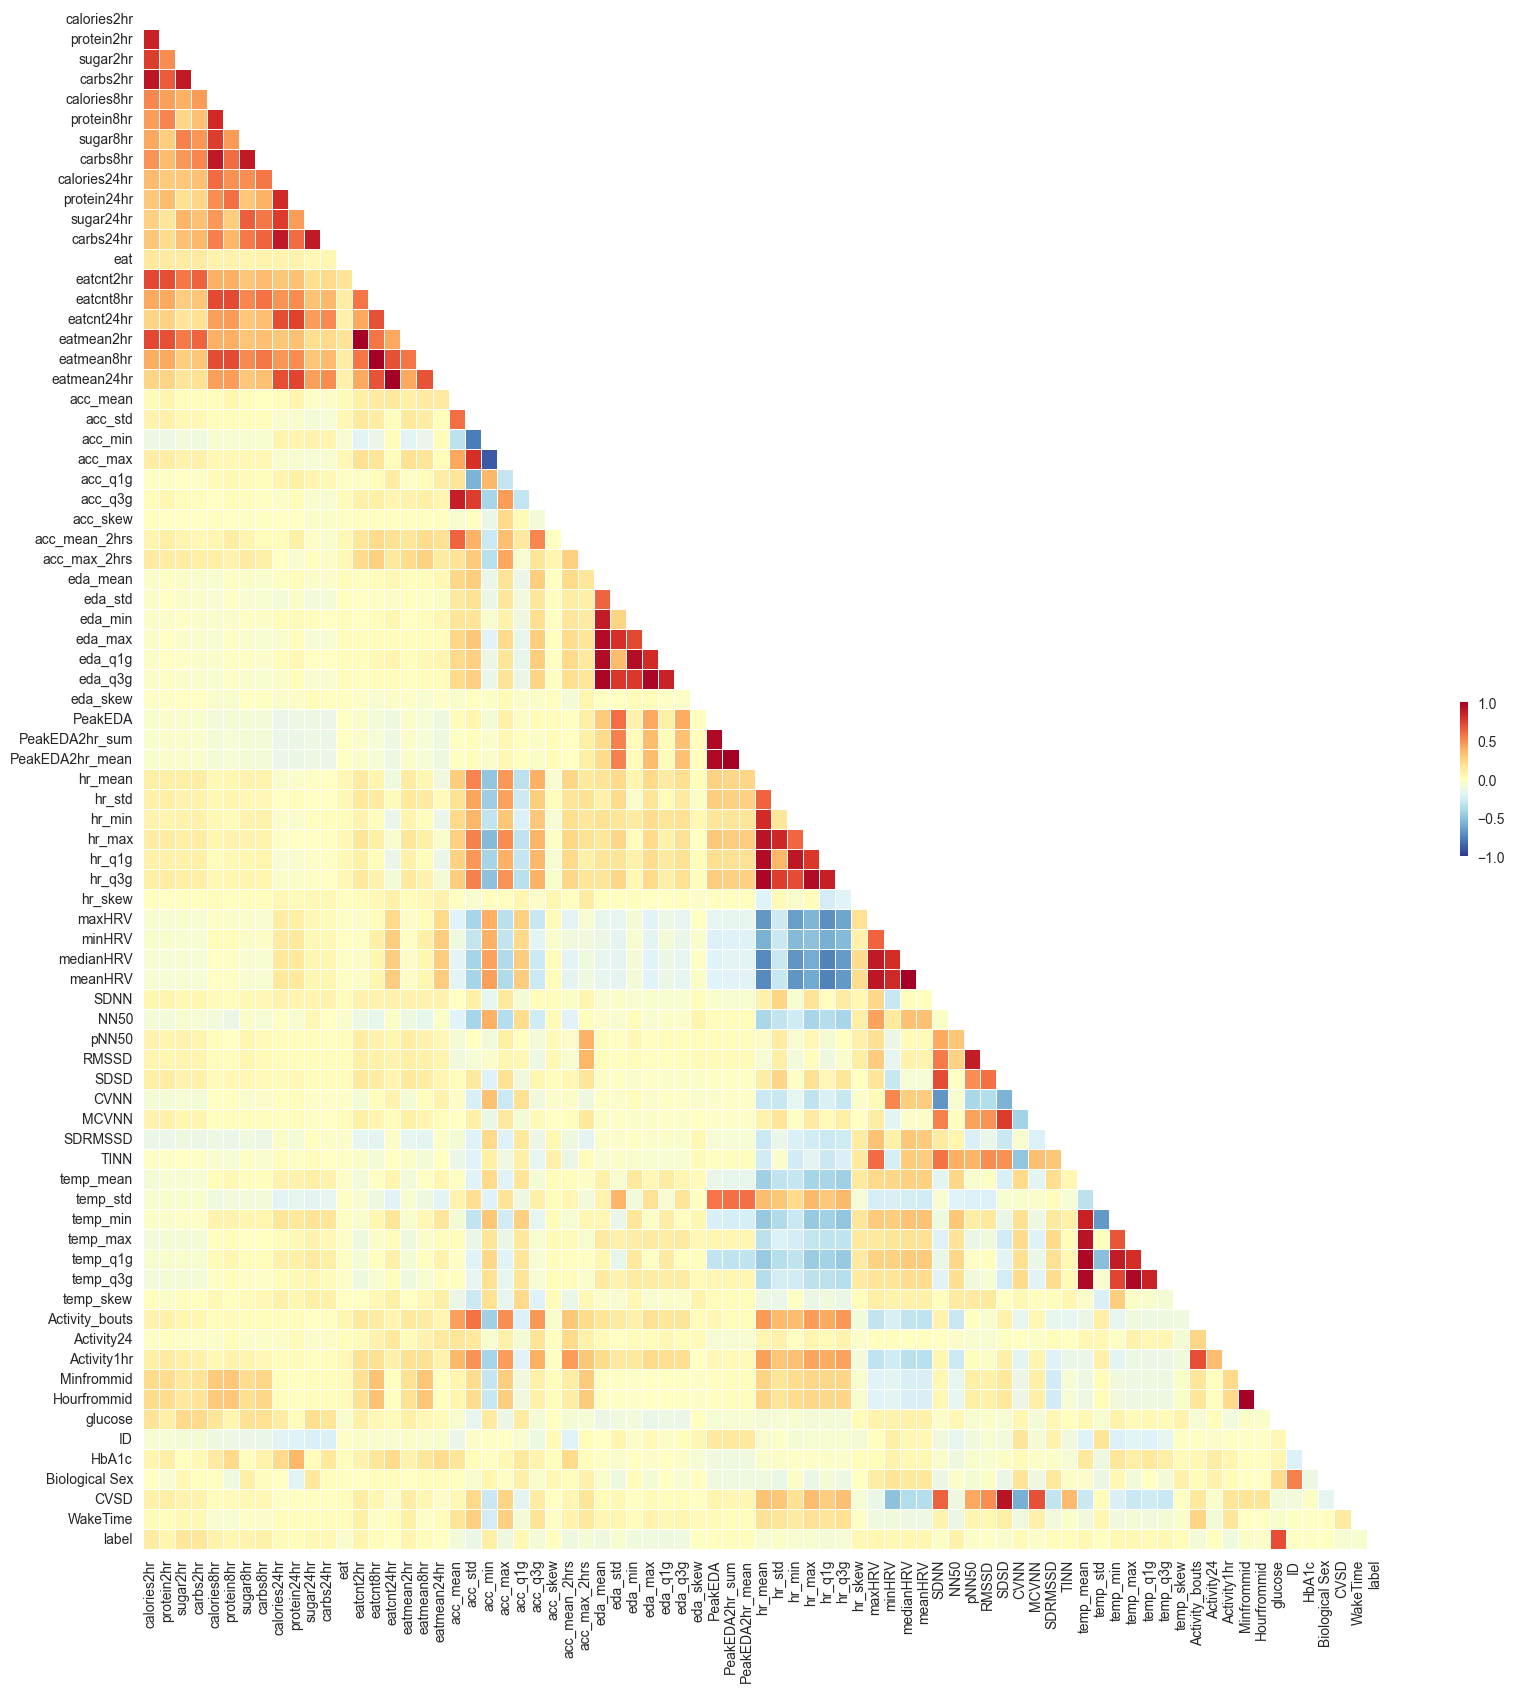

In [56]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### Leave-one-person-out cross validation : 최적의 MSE 평균을 내는 모델을 이용한 간질 포도당 예측

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, test_data = data_test, target='glucose')
    comp = compare_models()

    return comp

def loocvLGBMRegressor(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    # Make list of all ID's in idcolumn
    IDlist = list(set(data[idcolumn].astype(str))) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    
    for i in IDlist:
        comp = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn, numestimators)
        #TODO : comp로부터 각 모델 별 MAPE, MSE를 저장

        idt = str(i)
        print('...' + idt + ' processing complete.')

    #TODO : 위의 for문에서 저장한 각 모델 별 MAPE, MSE의 평균을 계산
    
    
    #TODO : RMSE의 평균이 가장 낮은 모델을 출력하기

    return 

In [57]:
import numpy as np
import pandas as pd
from pycaret.regression import setup, compare_models, predict_model

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = ids #str(ids)
    data[idcolumn] = data[idcolumn] #.apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, 
                test_data=data_test, 
                target=outcomevar, 
                feature_selection = True,
                feature_selection_method = 'classic', # or 'boruta' 
                n_features_to_select=15,
                pca=True,
                #feature_selection_estimator= ''
                verbose=False, 
                session_id = 123, #random state
                use_gpu = False)
    comp = compare_models(cross_validation=False, n_select=20, verbose=True)#, errors = 'raise')

    return comp, exp, data_test, y_test


def loocvModelCompareRegressor(data, idcolumn, outcomevar, dropcols=[]):
    IDlist = list(set(data[idcolumn].astype(int)))
    print(f'IDlist : {IDlist}')
    drop = [] #[idcolumn] to []
    drop = drop + dropcols
    
    model_errors = {}

    for i in IDlist:
        comp, exp, data_test, y_test = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn)
        
        for model in comp:
            model_name = model.__class__.__name__
            if model_name not in model_errors:
                model_errors[model_name] = {'MAPE': [], 'RMSE': []}
            
            # Predict on the test set
            predictions = predict_model(model, data=data_test, verbose=False)
            y_pred = predictions['prediction_label'] if 'prediction_label' in predictions.columns else predictions[outcomevar]
            
            # Calculate errors
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            mse = np.mean((y_test - y_pred) ** 2)
            rmse = np.sqrt(mse)

            model_errors[model_name]['MAPE'].append(mape)
            model_errors[model_name]['RMSE'].append(rmse)

    model_avg_errors = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in model_errors.items()}
    
    print(model_avg_errors)

    # Find the top 5 models with the lowest average RMSE
    sorted_models = sorted(model_avg_errors.items(), key=lambda item: item[1]['RMSE'])
    best_models = sorted_models[:5]
    best_model_names = [model[0] for model in best_models]
    best_model_errors = {model[0]: model[1] for model in best_models}

    print(f'Best models: {best_model_names}')
    print(f'Errors: {best_model_errors}')

    # Train the best models again on the full training data
    best_models = [model for model in comp if model.__class__.__name__ in best_model_names]

    return best_models, best_model_errors, data_test

In [58]:
best_models, best_model_errors, data_test = loocvModelCompareRegressor(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'])

IDlist : [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]
LOOCV_O : 1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,14.3158,322.8446,17.9679,-0.3329,0.1677,0.1437,0.8100
lar,Least Angle Regression,14.3158,322.8446,17.9679,-0.3329,0.1677,0.1437,0.7500
ridge,Ridge Regression,14.3745,324.2085,18.0058,-0.3385,0.1680,0.1443,0.7400
br,Bayesian Ridge,14.4460,326.2706,18.0630,-0.3471,0.1686,0.1451,0.7400
dummy,Dummy Regressor,15.5382,332.6456,18.2386,-0.3734,0.1710,0.1558,0.7400
llar,Lasso Least Angle Regression,15.5382,332.6455,18.2386,-0.3734,0.1710,0.1558,0.7300
huber,Huber Regressor,14.5115,358.0753,18.9229,-0.4784,0.1744,0.1452,1.2300
lasso,Lasso Regression,15.8932,372.1298,19.2907,-0.5364,0.1794,0.1608,0.7700
en,Elastic Net,15.8802,372.2376,19.2935,-0.5368,0.1794,0.1607,0.7500
omp,Orthogonal Matching Pursuit,16.6464,376.1286,19.3940,-0.5529,0.1810,0.1680,0.7000


LOOCV_O : 2


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,18.4480,558.6913,23.6367,-0.3181,0.1772,0.1356,0.7600
ada,AdaBoost Regressor,18.8716,560.0101,23.6645,-0.3212,0.1782,0.1405,3.4300
lasso,Lasso Regression,19.6561,605.5549,24.6080,-0.4286,0.1856,0.1460,0.7800
en,Elastic Net,19.6746,605.8551,24.6141,-0.4293,0.1856,0.1461,0.7500
dummy,Dummy Regressor,19.6993,638.9200,25.2769,-0.5073,0.1895,0.1417,0.7600
llar,Lasso Least Angle Regression,19.6993,638.9200,25.2769,-0.5073,0.1895,0.1417,0.7700
br,Bayesian Ridge,21.2214,698.2161,26.4238,-0.6472,0.2010,0.1552,0.7700
ridge,Ridge Regression,21.3100,703.4173,26.5220,-0.6595,0.2019,0.1557,0.8000
lar,Least Angle Regression,21.3778,704.6071,26.5444,-0.6623,0.2022,0.1565,0.8000
lr,Linear Regression,21.3778,704.6071,26.5444,-0.6623,0.2022,0.1565,0.8000


LOOCV_O : 3


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,13.4089,310.3106,17.6156,-0.0409,0.1578,0.1299,0.8200
lar,Least Angle Regression,13.4089,310.3106,17.6156,-0.0409,0.1578,0.1299,0.7100
ridge,Ridge Regression,13.4350,310.7074,17.6269,-0.0422,0.1579,0.1302,0.7000
br,Bayesian Ridge,13.4507,311.0721,17.6372,-0.0435,0.1581,0.1304,0.7200
et,Extra Trees Regressor,12.9607,311.1634,17.6398,-0.0438,0.1589,0.1271,1.7900
gbr,Gradient Boosting Regressor,13.1544,314.1994,17.7257,-0.0540,0.1593,0.1289,12.6200
lightgbm,Light Gradient Boosting Machine,13.0689,320.5859,17.9049,-0.0754,0.1595,0.1265,0.8600
en,Elastic Net,13.7575,322.0260,17.9451,-0.0802,0.1623,0.1354,0.7100
lasso,Lasso Regression,13.7791,323.0166,17.9727,-0.0835,0.1626,0.1357,0.7600
rf,Random Forest Regressor,13.7745,336.7620,18.3511,-0.1296,0.1647,0.1349,4.2400


LOOCV_O : 4


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,13.7688,335.9040,18.3277,-0.0368,0.1607,0.1287,0.7000
dummy,Dummy Regressor,13.7688,335.9040,18.3277,-0.0368,0.1607,0.1287,0.7300
omp,Orthogonal Matching Pursuit,13.7576,336.0014,18.3303,-0.0371,0.1591,0.1261,0.7200
lasso,Lasso Regression,13.9328,344.2761,18.5547,-0.0627,0.1606,0.1260,0.7400
en,Elastic Net,13.9439,345.1293,18.5777,-0.0653,0.1608,0.1261,0.7500
et,Extra Trees Regressor,15.1370,398.9898,19.9747,-0.2315,0.1740,0.1418,1.8600
huber,Huber Regressor,15.6330,409.2078,20.2289,-0.2631,0.1741,0.1346,1.2400
br,Bayesian Ridge,15.5058,410.2004,20.2534,-0.2661,0.1789,0.1497,0.7100
gbr,Gradient Boosting Regressor,15.1742,414.5296,20.3600,-0.2795,0.1784,0.1453,12.7100
ridge,Ridge Regression,15.6641,416.4682,20.4076,-0.2855,0.1802,0.1514,0.7000


LOOCV_O : 5


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,12.6689,254.4424,15.9513,-0.3231,0.1530,0.1330,12.8700
et,Extra Trees Regressor,12.7631,255.4399,15.9825,-0.3283,0.1530,0.1334,1.8400
lightgbm,Light Gradient Boosting Machine,12.5008,260.8899,16.1521,-0.3566,0.1530,0.1308,0.8800
ridge,Ridge Regression,13.3734,276.8880,16.6400,-0.4398,0.1600,0.1408,0.8100
lr,Linear Regression,13.3967,277.3703,16.6544,-0.4423,0.1601,0.1410,0.7700
lar,Least Angle Regression,13.3967,277.3703,16.6544,-0.4423,0.1601,0.1410,0.7300
br,Bayesian Ridge,13.3956,277.6562,16.6630,-0.4438,0.1602,0.1410,0.7200
rf,Random Forest Regressor,13.2785,281.8107,16.7872,-0.4654,0.1578,0.1379,4.3700
en,Elastic Net,13.8449,292.4528,17.1013,-0.5207,0.1642,0.1459,0.7200
lasso,Lasso Regression,13.8542,292.7387,17.1096,-0.5222,0.1643,0.1460,0.7400


LOOCV_O : 6


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,21.5205,782.7660,27.9780,0.1046,0.2057,0.1710,3.4800
lr,Linear Regression,20.3793,864.0325,29.3944,0.0116,0.2113,0.1491,0.8200
lar,Least Angle Regression,20.3793,864.0325,29.3944,0.0116,0.2113,0.1491,0.7200
ridge,Ridge Regression,20.3804,865.7992,29.4245,0.0096,0.2115,0.1491,0.7300
br,Bayesian Ridge,20.3783,866.9687,29.4443,0.0082,0.2116,0.1490,0.7700
et,Extra Trees Regressor,20.4313,867.9466,29.4609,0.0071,0.2095,0.1489,2.0500
lasso,Lasso Regression,20.3372,875.1491,29.5829,-0.0011,0.2122,0.1476,0.7300
en,Elastic Net,20.3529,877.7518,29.6269,-0.0041,0.2126,0.1477,0.7900
omp,Orthogonal Matching Pursuit,20.9577,887.5796,29.7923,-0.0153,0.2128,0.1550,0.7400
rf,Random Forest Regressor,20.6902,913.2360,30.2198,-0.0447,0.2157,0.1491,4.4400


LOOCV_O : 8


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,10.7258,195.5249,13.9830,0.1892,0.1201,0.0957,0.7700
lar,Least Angle Regression,10.7258,195.5249,13.9830,0.1892,0.1201,0.0957,0.8000
ridge,Ridge Regression,10.7282,196.4142,14.0148,0.1855,0.1204,0.0958,0.8000
br,Bayesian Ridge,10.7414,196.6082,14.0217,0.1847,0.1205,0.0960,0.7600
huber,Huber Regressor,10.5771,200.9766,14.1766,0.1665,0.1198,0.0913,1.2800
en,Elastic Net,11.1783,203.9465,14.2810,0.1542,0.1236,0.1012,0.7600
lasso,Lasso Regression,11.1805,204.1827,14.2893,0.1533,0.1237,0.1012,0.7500
et,Extra Trees Regressor,11.6241,216.4860,14.7135,0.1022,0.1253,0.1027,1.8200
gbr,Gradient Boosting Regressor,11.5582,219.3344,14.8099,0.0904,0.1265,0.1031,12.7100
lightgbm,Light Gradient Boosting Machine,11.8454,227.1703,15.0722,0.0579,0.1283,0.1053,0.9800


LOOCV_O : 9


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,17.6538,598.9461,24.4734,-0.1089,0.1775,0.1297,0.7400
ada,AdaBoost Regressor,18.3828,599.7920,24.4907,-0.1105,0.1815,0.1458,4.4300
br,Bayesian Ridge,17.7279,603.6332,24.5689,-0.1176,0.1782,0.1300,0.7900
lr,Linear Regression,17.7492,605.9073,24.6152,-0.1218,0.1787,0.1304,0.7800
lar,Least Angle Regression,17.7492,605.9073,24.6152,-0.1218,0.1787,0.1304,0.7200
huber,Huber Regressor,18.0419,641.2208,25.3223,-0.1872,0.1837,0.1298,1.2500
lasso,Lasso Regression,18.3446,650.3666,25.5023,-0.2041,0.1854,0.1327,0.7100
en,Elastic Net,18.3737,650.9965,25.5146,-0.2053,0.1856,0.1329,0.7500
dummy,Dummy Regressor,18.4088,677.6556,26.0318,-0.2547,0.1886,0.1329,0.7500
llar,Lasso Least Angle Regression,18.4088,677.6556,26.0318,-0.2547,0.1886,0.1329,0.7100


LOOCV_O : 10


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,21.6783,856.7767,29.2707,0.0182,0.2341,0.1971,0.7700
en,Elastic Net,21.7048,857.5872,29.2846,0.0172,0.2342,0.1975,0.7500
omp,Orthogonal Matching Pursuit,20.7304,878.8454,29.6453,-0.0071,0.2329,0.1820,0.7000
gbr,Gradient Boosting Regressor,22.0027,883.6877,29.7269,-0.0127,0.2385,0.2011,13.0800
et,Extra Trees Regressor,22.2735,890.9209,29.8483,-0.0210,0.2397,0.2032,1.8400
dummy,Dummy Regressor,21.9367,896.4714,29.9411,-0.0273,0.2396,0.1991,0.7600
llar,Lasso Least Angle Regression,21.9367,896.4715,29.9411,-0.0273,0.2396,0.1991,0.7100
br,Bayesian Ridge,23.0030,897.7853,29.9631,-0.0288,0.2424,0.2126,0.7300
lar,Least Angle Regression,23.1339,900.5723,30.0095,-0.0320,0.2433,0.2142,0.7500
lr,Linear Regression,23.1339,900.5723,30.0095,-0.0320,0.2433,0.2142,0.7900


LOOCV_O : 11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,18.3526,575.4547,23.9886,0.0254,0.1880,0.1504,0.7200
et,Extra Trees Regressor,19.4054,587.9497,24.2477,0.0043,0.1930,0.1655,1.8000
dummy,Dummy Regressor,18.6166,608.0514,24.6587,-0.0298,0.1932,0.1509,0.7400
llar,Lasso Least Angle Regression,18.6166,608.0515,24.6587,-0.0298,0.1932,0.1509,0.7200
lightgbm,Light Gradient Boosting Machine,19.3557,608.3109,24.6640,-0.0302,0.1945,0.1658,0.8900
gbr,Gradient Boosting Regressor,19.5914,628.8430,25.0767,-0.0650,0.1972,0.1670,12.5100
lasso,Lasso Regression,19.0809,636.4926,25.2288,-0.0780,0.1952,0.1599,0.7500
en,Elastic Net,19.1351,637.5958,25.2507,-0.0798,0.1955,0.1606,0.7600
huber,Huber Regressor,18.6139,640.1950,25.3021,-0.0842,0.1950,0.1505,1.2300
rf,Random Forest Regressor,20.1942,657.9486,25.6505,-0.1143,0.2015,0.1725,4.2700


LOOCV_O : 12


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,12.6077,362.0335,19.0272,0.1138,0.1419,0.0954,0.7000
lasso,Lasso Regression,12.6345,363.0649,19.0543,0.1113,0.1421,0.0956,0.6900
et,Extra Trees Regressor,13.6655,368.2931,19.1910,0.0985,0.1454,0.1059,1.7800
rf,Random Forest Regressor,13.8464,368.8274,19.2049,0.0972,0.1478,0.1095,4.2800
br,Bayesian Ridge,13.4544,400.1882,20.0047,0.0204,0.1497,0.1003,0.7000
ridge,Ridge Regression,13.5211,402.6294,20.0656,0.0144,0.1502,0.1008,0.7000
ada,AdaBoost Regressor,15.5724,404.6711,20.1164,0.0094,0.1565,0.1293,3.6300
lar,Least Angle Regression,13.5592,407.8643,20.1956,0.0016,0.1513,0.1011,0.7300
lr,Linear Regression,13.5592,407.8643,20.1956,0.0016,0.1513,0.1011,0.7400
gbr,Gradient Boosting Regressor,14.1434,411.6537,20.2893,-0.0077,0.1545,0.1077,10.0400


LOOCV_O : 13


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,15.7447,604.1997,24.5805,-0.2660,0.1716,0.1094,3.4800
llar,Lasso Least Angle Regression,18.6961,700.3523,26.4642,-0.4675,0.1877,0.1297,0.7200
dummy,Dummy Regressor,18.6961,700.3523,26.4642,-0.4675,0.1877,0.1297,0.7200
par,Passive Aggressive Regressor,19.6811,768.1094,27.7148,-0.6094,0.2015,0.1407,0.9700
ridge,Ridge Regression,21.2856,888.2186,29.8030,-0.8611,0.2182,0.1467,0.7200
br,Bayesian Ridge,21.3095,889.1457,29.8185,-0.8630,0.2183,0.1468,0.7100
lr,Linear Regression,21.4303,896.2590,29.9376,-0.8779,0.2194,0.1477,0.7600
lar,Least Angle Regression,21.4303,896.2590,29.9376,-0.8779,0.2194,0.1477,0.7000
gbr,Gradient Boosting Regressor,21.8919,905.3809,30.0895,-0.8971,0.2210,0.1516,9.8500
en,Elastic Net,21.8952,917.7440,30.2943,-0.9230,0.2228,0.1511,0.7200


LOOCV_O : 14


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,15.0537,406.7256,20.1674,0.0706,0.1613,0.1261,1.2400
br,Bayesian Ridge,15.5169,410.0973,20.2509,0.0629,0.1635,0.1329,0.7200
lasso,Lasso Regression,15.6750,410.3815,20.2579,0.0623,0.1645,0.1357,0.7000
ridge,Ridge Regression,15.5327,410.5456,20.2619,0.0619,0.1636,0.1331,0.7000
en,Elastic Net,15.6917,410.9121,20.2710,0.0611,0.1646,0.1359,0.7400
et,Extra Trees Regressor,15.4059,411.6406,20.2889,0.0594,0.1637,0.1314,1.7500
lr,Linear Regression,15.5934,412.1816,20.3023,0.0582,0.1641,0.1338,0.7800
lar,Least Angle Regression,15.5934,412.1816,20.3023,0.0582,0.1641,0.1338,0.6800
omp,Orthogonal Matching Pursuit,15.4811,416.5313,20.4091,0.0482,0.1649,0.1330,0.7400
lightgbm,Light Gradient Boosting Machine,15.8924,426.2084,20.6448,0.0261,0.1664,0.1355,0.8700


LOOCV_O : 15


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,12.8022,259.0681,16.0956,-0.1962,0.1434,0.1185,9.8500
llar,Lasso Least Angle Regression,12.9524,266.8575,16.3358,-0.2321,0.1480,0.1260,0.7000
dummy,Dummy Regressor,12.9524,266.8575,16.3358,-0.2321,0.1480,0.1260,0.7300
lightgbm,Light Gradient Boosting Machine,14.6732,326.6770,18.0742,-0.5083,0.1602,0.1357,0.8200
et,Extra Trees Regressor,15.8716,376.4826,19.4032,-0.7383,0.1721,0.1494,1.8200
knn,K Neighbors Regressor,16.2530,413.7654,20.3412,-0.9104,0.1842,0.1495,0.8200
lasso,Lasso Regression,16.8230,497.4329,22.3032,-1.2967,0.1898,0.1626,0.7600
en,Elastic Net,17.0233,512.5658,22.6399,-1.3666,0.1921,0.1646,0.7500
br,Bayesian Ridge,17.1018,518.5525,22.7717,-1.3943,0.1930,0.1654,0.7100
lar,Least Angle Regression,17.5710,539.4690,23.2265,-1.4908,0.1964,0.1700,0.7100


LOOCV_O : 16


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,13.8753,327.3876,18.0939,-0.1334,0.1657,0.1351,1.2000
ridge,Ridge Regression,16.1710,381.7908,19.5395,-0.3218,0.1815,0.1624,0.7300
lr,Linear Regression,16.2211,383.3830,19.5802,-0.3273,0.1819,0.1629,0.7500
lar,Least Angle Regression,16.2211,383.3830,19.5802,-0.3273,0.1819,0.1629,0.7200
br,Bayesian Ridge,16.2284,383.4722,19.5824,-0.3276,0.1819,0.1630,0.7100
lasso,Lasso Regression,16.7851,400.5879,20.0147,-0.3868,0.1859,0.1691,0.7300
en,Elastic Net,16.7893,400.7199,20.0180,-0.3873,0.1860,0.1691,0.7100
omp,Orthogonal Matching Pursuit,17.6537,421.3978,20.5280,-0.4589,0.1915,0.1794,0.7100
dummy,Dummy Regressor,17.8049,428.2303,20.6937,-0.4825,0.1930,0.1812,0.7400
llar,Lasso Least Angle Regression,17.8049,428.2303,20.6937,-0.4825,0.1930,0.1812,0.7100


{'LinearRegression': {'MAPE': 14.805482791159907, 'RMSE': 22.52761511496033}, 'Lars': {'MAPE': 14.80548279115894, 'RMSE': 22.527615114958646}, 'Ridge': {'MAPE': 14.780503366013814, 'RMSE': 22.502167807401108}, 'BayesianRidge': {'MAPE': 14.733995036552777, 'RMSE': 22.460014638509904}, 'DummyRegressor': {'MAPE': 14.444269493777215, 'RMSE': 22.23342980935409}, 'LassoLars': {'MAPE': 14.444269230125858, 'RMSE': 22.2334295891243}, 'HuberRegressor': {'MAPE': 15.023241780682316, 'RMSE': 23.91601155529782}, 'Lasso': {'MAPE': 14.44735196933579, 'RMSE': 22.222355264188117}, 'ElasticNet': {'MAPE': 14.467030175300332, 'RMSE': 22.24931021468674}, 'OrthogonalMatchingPursuit': {'MAPE': 14.805215568656825, 'RMSE': 22.746479757994702}, 'ExtraTreesRegressor': {'MAPE': 15.362696568503656, 'RMSE': 23.004552471138037}, 'GradientBoostingRegressor': {'MAPE': 15.11502071456203, 'RMSE': 22.84595472328598}, 'LGBMRegressor': {'MAPE': 15.48164839430448, 'RMSE': 23.456934616319085}, 'RandomForestRegressor': {'MAPE'

In [59]:
tuned_model = tune_model(best_models[0])  # 변경된 부분

predictions = predict_model(tuned_model, data=data_test, verbose=False)
y_pred = predictions['prediction_label'] if 'prediction_label' in predictions.columns else predictions['glucose']
y_test = data_test['glucose']

print("##### TUNED #####")
# Calculate errors
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
print(f'MAPE : {mape}')
print(f'RMSE : {rmse}')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:00:43
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [ ]:
# Plot feature importance for the best model
#plot_model(best_model, plot='feature')